# PyTorch Neural Network training (overfitting example)
In this notebook, we'll show how to train a shallow ResNet network on keypoints estimation task with synthetic data. To make the notebook fast to run, we'll use a small dataset of 100 images and overfit the network to this dataset.

## Imports

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import models
import matplotlib.pyplot as plt
import cv2
from imgaug import augmenters as iaa
from mpl_toolkits.axes_grid1 import ImageGrid

import datagen
from dghelpers import imshow

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Constants definition
The train and test data is located in the main directory. We save a checkpoint of the network locally. The dataset is splitted into 90 train images and 10 test images

In [2]:
DATASET_PATH= '../Training Set'
MODEL_PATH = "model.pth"
IMG_SIZE = 128
BATCH_SIZE = 45 # Ideally should be a power of 2 for efficiency
TRAIN_TEST_RATIO = 0.9
EPOCHS = 100
NUMBER_OF_KEYPOINTS = 68

## Network definition
We use a ResNet-18 network and replace the last fully connected layer with a dense layer that regresses the keypoints locations

In [3]:
# Model functions
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn_stack = models.resnet18(pretrained=True)
        self.cnn_stack.fc = nn.Linear(self.cnn_stack.fc.in_features, NUMBER_OF_KEYPOINTS * 2)

    def forward(self, x):
        return self.cnn_stack(x)

## Datagen Dataset class definition
We define a custom Dataset class using Datagen's data loader

In [4]:
class DGDataset(Dataset):
    def __init__(self, dataset, Xy_accessor, with_augmentations):
        # A Datagen data loader object (generated using datagen.load)
        self.dataset = dataset
        # Generic functions that take a data loader object as parameter and extract the relavant 
        # input and output data for the network
        self.Xy_accessor = Xy_accessor
        self.with_augmentations = with_augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        return self.Xy_accessor(datapoint, with_augmentations=self.with_augmentations)

## Train and test functions

In [5]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    model.train()
    epoch_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        epoch_losses += [loss]
    scheduler.step()
    return np.mean(epoch_losses)


def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

## Data preparation and augmentations
We use Datagen's data laoder to seamlessly load the data without having to parse the files.

In [6]:
ds = datagen.load(DATASET_PATH)

Let's define some augmentations for our data. The augmentations will increase the dataset diversity and make the model more robust.<br>
We will use gaussian blur and noise, scaling, translation, rotation and cropping augmentations. <b>imgaug</b> will automatically adapt the keypoints to the geometric augmentations performed on the image.

In [7]:
def augment(img, keypoints):
    seq = iaa.Sometimes(0.8, 
            iaa.Sequential([
                iaa.OneOf([
                    iaa.GaussianBlur(sigma=(0, 2.0)), 
                    iaa.AdditiveGaussianNoise(scale=(0, 0.08*255))]),
                iaa.OneOf([
                    iaa.Affine(scale=(0.75, 1.25)), 
                    iaa.Affine(translate_percent=(0, 0.2)), 
                    iaa.Affine(rotate=(-20, 20))]),
                iaa.Crop(percent=(0, 0.2))]))
    img_augmented, keypoints_augmented = seq(images=[img], keypoints=[np.flip(keypoints)])
    return img_augmented[0], np.flip(keypoints_augmented[0])

Let's show some examples of augmentations:

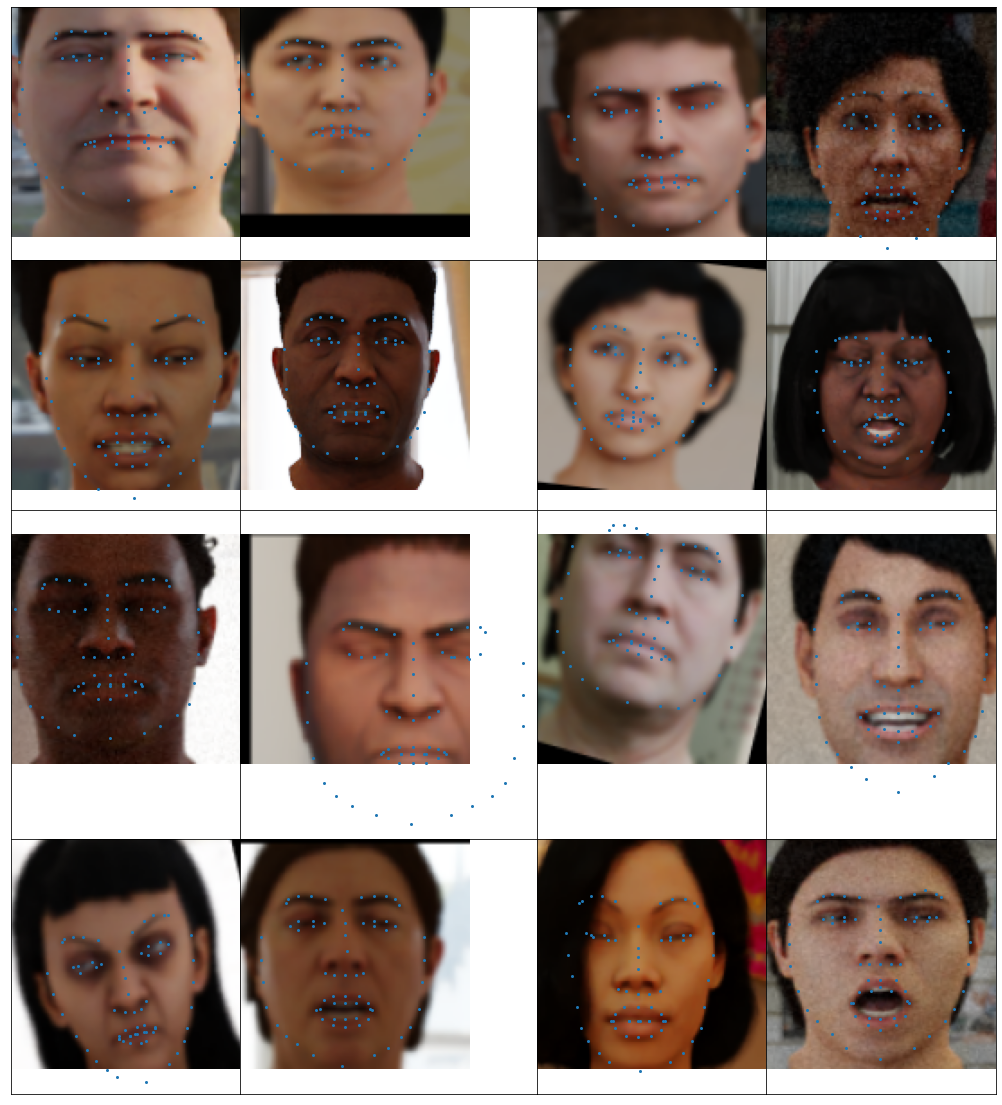

In [8]:
fig_shape = np.array((4, 4))
fig_size = 5 * fig_shape
fig = plt.figure(figsize=fig_size)
grid = ImageGrid(fig, 111, nrows_ncols=fig_shape, axes_pad=0.)

for i, ax in enumerate(grid):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    img_augmented, keypoints_augmented = augment(ds[i].visible_spectrum, ds[i].keypoints.face.standard.coords_2d)
    ax.imshow(img_augmented)
    ax.scatter(*np.flip(keypoints_augmented).T, s=4)

We define a function to access the image and its label from a single datapoint, and perform all the pre-processing.<br>
The keypoints array is being flattened and normalized to image size so that the networks predicts values in the [0..1] range. This makes the training process more stable.

In [9]:
def Xy_accessor(dp, with_augmentations=False):
    img = dp.visible_spectrum
    keypoints = dp.keypoints.face.standard.coords_2d
    if with_augmentations:
        img, keypoints = augment(img, keypoints)
    img = ToTensor()(img)
    keypoints = torch.tensor((keypoints.flatten()/IMG_SIZE).astype('float32'))
    return img, keypoints

We split the dataset into train and test sets and create two PyTorch data loaders. <br>
Augmentations are applied only to training data.

In [10]:
train_set_size = int(TRAIN_TEST_RATIO * len(ds))
training_data = DGDataset(ds[:train_set_size], Xy_accessor, with_augmentations=True)
test_data = DGDataset(ds[train_set_size:], Xy_accessor, with_augmentations=False)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

## Training setup
We use Adam optimizer with MSE loss and exponential learning rate decay

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.97)

If a weight file already exists, lets load it. Otherwise, a new one will be created during training.

In [12]:
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint)

## Training loop
Since our test set is simpler and does not include any augmentation, the test loss might be lower than the train loss.

Training complete!


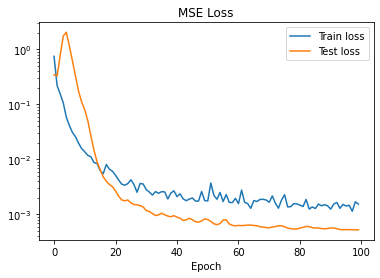

In [13]:
from IPython import display

train_losses = []
test_losses = []
for t in range(EPOCHS):
    display.display(plt.gcf())
    train_loss = train(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_losses += [train_loss]
    test_loss = test(test_dataloader, model, loss_fn)
    test_losses += [test_loss]
    torch.save(model.state_dict(), MODEL_PATH)
    plt.clf()
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.title('MSE Loss')
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.legend()
    display.clear_output(wait=True)

print("Training complete!")

## Visualization of the results on the test set
Since the network was overfitted on a very small amount of data, the results on test data are not optimal. <br> Nonetheless, the augmentations made the network much more robust and we can still see nice results on test data.

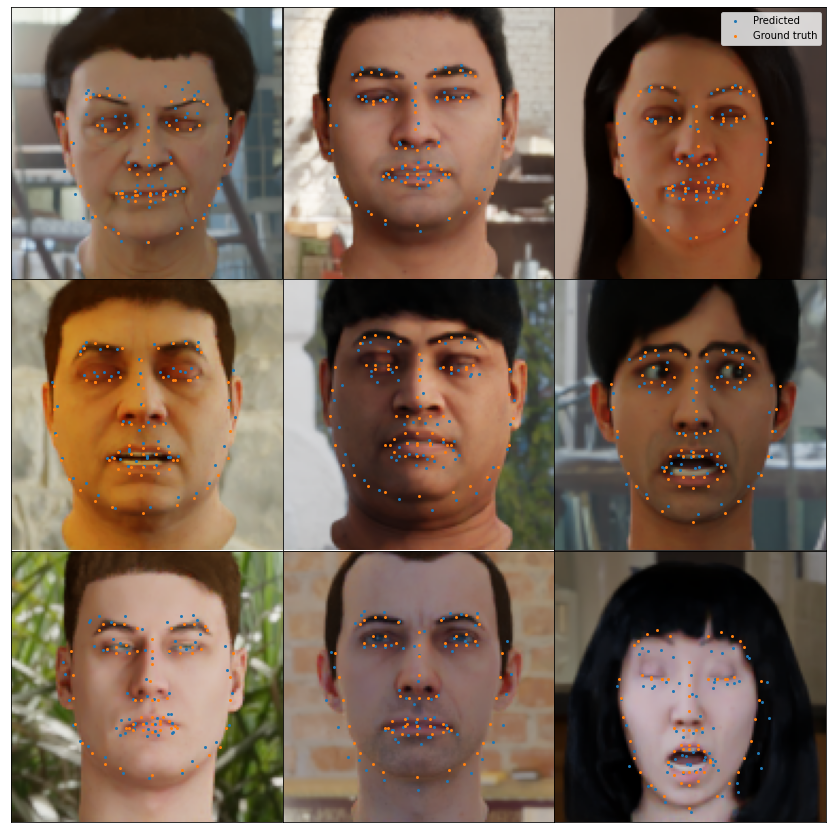

In [14]:
model.eval()
X, y = next(iter(test_dataloader))
X = X.to(device)
y_pred = model(X).detach().numpy()
X = X.detach().numpy()
y = y.detach().numpy()

fig_shape = np.array((3, 3))
fig_size = 5 * fig_shape
fig = plt.figure(figsize=fig_size)
grid = ImageGrid(fig, 111, nrows_ncols=fig_shape, axes_pad=0.)

for i, (ax, img, lms_pred, lms_gt) in enumerate(zip(grid, X, y_pred, y)):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    lms_gt = lms_gt.reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE
    lms_pred = lms_pred.reshape(NUMBER_OF_KEYPOINTS, 2) * IMG_SIZE
    ax.imshow(np.moveaxis(img, 0, -1))
    ax.scatter(*np.flip(lms_pred).T, s=4, label='Predicted')
    ax.scatter(*np.flip(lms_gt).T, s=4, label='Ground truth')
    if i == 2:
        ax.legend()
